In [1]:
from pyomo.environ import *
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### Prepare data

In [2]:
def LoadProperMatrix(csv_filename):
    # Load matrix
    df = pd.read_csv(csv_filename)
    
    # make the first column index
    df.index = df['url']
    df = df.drop(columns = ['url'])
    return df    

In [3]:
# Load Rating, Ingredients, and Nutrition matrix
RatingMat = LoadProperMatrix('CompleteRatingsMatrix.csv')
IngredientMat = LoadProperMatrix('IngredientMatrix.csv')
NutritionMat = LoadProperMatrix('NutritionMatrix.csv')
TimeMat = LoadProperMatrix('TimeMatrix.csv')

In [4]:
# Names of all users, recipes, ingredients, and nutritions
users = RatingMat.index
recipes = RatingMat.columns
ingredients = IngredientMat.columns
nutritions = NutritionMat.columns

### Parameters

In [5]:
data = {
    "NumberOfRecipes": len(recipes),
    "AvailableTime":[[60,30,0,30,60],[60,0,60,60,0]],
    "Ratings":RatingMat.iloc[0:2, :].values.tolist(),
    "NutritionMatrix":[list(NutritionMat.iloc[r]) for r in range(len(recipes))],
    "CookingTime":TimeMat.time.values,
    "NutritionBounds": [
        [[10,60],[400,1200],[80,150],[800,2000],[20,50],[80,200]],
        [[10,60],[400,1200],[80,150],[800,2000],[20,50],[80,200]]],
    "DishesPerDay":[1,2],
    "MaxDishesMadePerDay":3,
    "RepeatedRecipe": 2,
    "IngredientMatrix":[list(IngredientMat.iloc[r]) for r in range(len(recipes))],
    "IngredientFondness": [[3 for i in range(len(ingredients))],
                            [3 for i in range(len(ingredients))]],
    "TotalDays":5
}

### Model Class

In [6]:
class modelClass():
    
    # decorator
    def _timer(func):
        import time
        def wrapper(*args, **kwargs):
            t1 = time.perf_counter()
            result = func( *args, **kwargs)
            print(func.__name__," executes", round(time.perf_counter() - t1,3),'s')
            return result
        return wrapper
    
    def __init__(self, data, solver = "cplex"):
        
        # public abstract model
        self.model = None
        
        # public model instance
        self.instance = None
        
        # public data
        self.d = data
        
        # public optimal solutions 
        self.xs = []
        self.ys = []
        
        # public results
        self.results = None
        
        # private classified optimal solutions (for solving alternative optima) 
        self.__x0 = []
        self.__x1 = []
        self.__y0 = []
        self.__y1 = []
        
        # private solver
        self.__solver = solver
        
        # private helper variables
        self.__K = self.d["NumberOfRecipes"]
        self.__I = len(self.d["IngredientMatrix"][0])
        self.__N = len(self.d["NutritionMatrix"][0])
        self.__dd = data["TotalDays"]
        self.__counter = 0
        
        
        # build the basic model when initialized
        self.BuildBasicModel()
        
    @_timer    
    def BuildBasicModel(self):
        # length of recipes
        K = self.__K
        
        # length of ingredients
        I = self.__I
        
        # length of nutritions
        N = self.__N 
        
        # total amount of days
        dd = self.__dd 
        
        # data
        data = self.d
        
        # create abstract model
        m = AbstractModel()
        
        # dummy variables
        m.p = range(2)
        m.d = range(dd)
        m.k = range(K)        

        # decision variables
        m.x = Var(m.d, m.k, domain = Binary)
        m.y = Var(m.p, m.d, m.k, domain = Binary)


        # daily number of meals constraits 
        m.MinMealPerDay = Constraint(m.d, rule = lambda m, d: np.sum([m.x[d,k] for k in range(K)]) >= data["DishesPerDay"][0])
        m.MaxMealPerDay = Constraint(m.d, rule = lambda m, d: np.sum([m.x[d,k] for k in range(K)]) <= data["DishesPerDay"][1])

        # nutrition constraints
        m.NutritionLowerBounds = Constraint(range(N), m.p, m.d, 
                            rule = lambda m, n, p, d: np.sum([m.x[d,k]*data["NutritionMatrix"][k][n] for k in range(K)]) 
                                            >= data["NutritionBounds"][p][n][0])
        m.NutritionUpperBounds = Constraint(range(N), m.p, m.d, 
                            rule = lambda m, n, p, d: np.sum([m.x[d,k]*data["NutritionMatrix"][k][n] for k in range(K)]) 
                                            <= data["NutritionBounds"][p][n][1])

        # total available time constraints
        m.TotalAvailableTime = Constraint(m.p, m.d, 
                            rule = lambda m, p, d: np.sum([m.y[p,d,k]*data["CookingTime"][k] for k in range(K)]) 
                                          <= data["AvailableTime"][p][d])

        # number of made dishes per day
        m.MadeDishesLowerBound = Constraint(m.p, m.d, rule = lambda m, p, d: np.sum([m.y[p,d,k] for k in range(K)]) 
                                            <= data["MaxDishesMadePerDay"])

        # two people cannot cook the same dish
        m.NoOverlap = Constraint(
            rule = lambda m: np.sum([[m.y[0,d,k]*m.y[1,d,k] for d in range(dd)] for k in range(K)]) <= 0)

        # each recipe should not repeat # times
        m.Repetition = Constraint(m.k,
            rule = lambda m, k: np.sum([m.x[d,k] for d in range(dd)]) <= data["RepeatedRecipe"])
        
        
        # y = x
        # m.Equality = Constraint(rule = lambda m: np.sum([[(m.y[0,d,k] + m.y[1,d,k]) for d in range(dd)]for k in range(K)])
        #                       - np.sum([[m.x[d,k] for d in range(dd)]for k in range(K)]) == 0)

        # schedual constraints
        # m.LastDay = Constraint(
        #     rule = lambda m: np.sum([[((m.y[0,d,k] + m.y[1,d,k]) - m.x[d,k]) * m.x[d,k] for d in range(dd)]for k in range(K)]) >= -0.5)

        m.Recipe = Constraint(m.k,
            rule = lambda m, k: np.sum([(5-d) * (m.y[0,d,k] + m.y[1,d,k] - m.x[d,k]) for d in range(dd)]) >= 0)

        m.Equality = Constraint(m.k,
            rule = lambda m, k: np.sum([(m.y[0,d,k] + m.y[1,d,k] - m.x[d,k]) for d in range(dd)]) == 0)

        #objective function
        def obj_func(m):            
            expr = np.sum([[(data["Ratings"][0][k] + data["Ratings"][1][k])*m.x[d,k] for d in range(dd)] for k in range(K)])
            - np.sum([[[(dd-2*d)*(data["AvailableTime"][p][d] - data["CookingTime"][k]*m.y[p,d,k]) for p in range(2)] for d in range(dd)] for k in range(K)]) 
            + np.sum([[[[(data["IngredientFondness"][p][i] - data["IngredientMatrix"][k][i])*m.x[d,k] for i in range(I)] 
                        for p in range(2)] for d in range(dd)] for k in range(K)])
            return expr
        m.Obj = Objective(rule = obj_func,sense = maximize)
        
        # restore the model 
        self.model = m
    
    @_timer    
    def SolveForAlternative(self):
        # If the model does not exists
        if not self.model:
            print("The model has not been solved yet.")
            return
        # If the model is not feasible
        if not self.xs:
            print("The model is not feasible")
            return
        
        len_x1 = len(self.__x1)
        self.model.add_component("Additional" + str(self.__counter),\
           Constraint(rule = lambda m: np.sum([m.x[l[0],l[1]] for l in self.__x1]) 
                      - np.sum([m.x[o[0],o[0]] for o in self.__x0]) <= len_x1 - 1))
        self.__counter += 1
        self.Solve()
    
    @_timer    
    def Solve(self, verbose = False):
        # instantiate the model
        self.instance = self.model.create_instance()
        
        # initialization is really important when calculations are needed in the constraints
        for p in range(2):
            for d in range(self.__dd):
                for k in range(self.__K):
                    self.instance.y[p,d,k] = 0
        for d in range(self.__dd):
            for k in range(self.__K):
                self.instance.x[d,k] = 0                
        
        #solve
        cpx = SolverFactory(self.__solver)
        self.results = cpx.solve(self.instance)
        if verbose:
            self.instance.display()
        
        #restore solution
        self.xs = list(self.getXs())
        self.ys = list(self.getYs())
        
        if self.xs:
            self.__x0 = list(self.getXs(0))
            self.__x1 = self.xs
            self.__y0 = list(self.getYs(0))
            self.__y1 = self.ys
            self.VisualizeY()
            self.VisualizeX()        
        else:
            print("The model is not feasible.")
        
       
    def getYs(self, v = 1):
        for i in range(2):
            for j in range(self.__dd):
                for k in range(self.__K):
                    if (abs(self.instance.y[i,j,k]() - v) <= 0.01):
                        yield (i,j,k)
                         
    def getXs(self, v = 1):
        for j in range(self.__dd):
            for k in range(self.__K):
                if (abs(self.instance.x[j,k]() - v) <= 0.01):
                    yield (j,k)
                       
    def VisualizeY(self):
        minPerDay =2.5*60
        schedule = pd.DataFrame(self.ys)
        PERSON = range(2)
        makespan = minPerDay

        bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
        text_style = {'color':'black', 'weight':'bold', 'ha':'center', 'va':'center'}
        colors = mpl.cm.Dark2.colors

        fig, ax = plt.subplots(1,1, figsize=(13, 3))

        xs = xf = 0
        pre_person = 0
        pre_day = -1
        for r in self.ys:
            person = r[0] + 1
            day = r[1]
            recipe = r[2]
            if pre_person != person:
                xf = 0
            pre_person = person

            if pre_day != day:
                xf = day*minPerDay
            pre_day = day
            xs = xf 
            xf = xs + self.d["CookingTime"][recipe]
            ax.plot([xs, xf], [person]*2, c=colors[recipe%7], **bar_style)
            ax.text((xs + xf)/2, person, str(recipe), **text_style)

        ax.set_title('Cooking Schedule')
        ax.set_ylabel('Person')

        ax.set_ylim(0.5, 2.5)
        ax.set_yticks(range(1, 1 + 2))
        ax.set_yticklabels(range(2))
        ax.set_xlabel('Time (min)')
        ax.grid(True)
        for day in range(5):
            ax.plot([day * minPerDay]*2, ax.get_ylim(), 'r--')

        fig.tight_layout()
        plt.show()
           
    def VisualizeX(self):
        minPerDay =2.5*60
        schedule = pd.DataFrame(self.xs)
        makespan = minPerDay

        bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
        text_style = {'color':'black', 'weight':'bold', 'ha':'center', 'va':'center'}
        colors = mpl.cm.Dark2.colors

        fig, ax = plt.subplots(1,1, figsize=(13, 3))

        xs = xf = 0
        pre_day = -1
        for r in self.xs:
            day = r[0]
            recipe = r[1]        
            if pre_day != day:
                xf = day*minPerDay
            pre_day = day
            xs = xf 
            xf = xs + 30
            ax.plot([xs, xf], [1]*2, c=colors[recipe%7], **bar_style)
            ax.text((xs + xf)/2, 1, str(recipe), **text_style)

        ax.set_title('Recommended Recipes for each day')
        ax.set_ylabel('Recipes')

        ax.set_ylim(0.5, 1.5)
        ax.set_yticks(range(1))
        ax.set_yticklabels(range(2))
        ax.set_xlabel('Time (min)')
        ax.grid(True)
        for day in range(5):
            ax.plot([day * minPerDay]*2, ax.get_ylim(), 'r--')

        fig.tight_layout()
        plt.show()
        

Solution1:
BuildBasicModel  executes 0.001 s


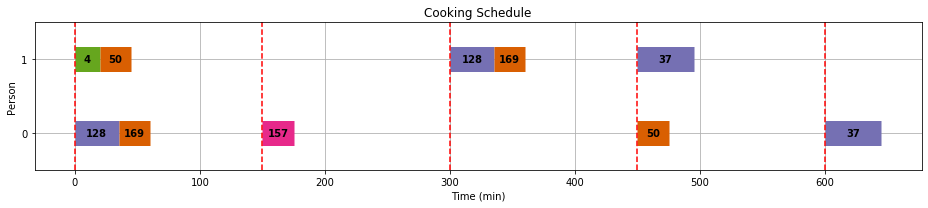

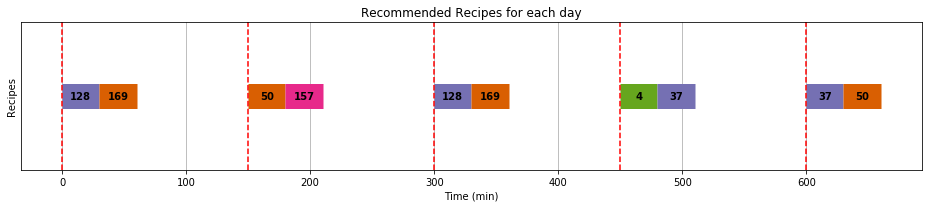

Solve  executes 2.23 s
Ys: [(0, 0, 128), (0, 0, 169), (0, 1, 157), (0, 3, 50), (0, 4, 37), (1, 0, 4), (1, 0, 50), (1, 2, 128), (1, 2, 169), (1, 3, 37)]
Xs: [(0, 128), (0, 169), (1, 50), (1, 157), (2, 128), (2, 169), (3, 4), (3, 37), (4, 37), (4, 50)]
----------------------------------------------------------------------------------------------------
Solution2 :


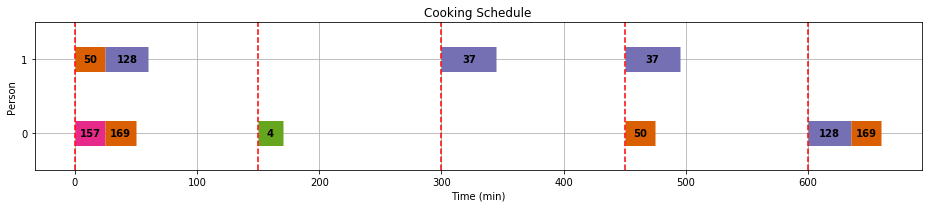

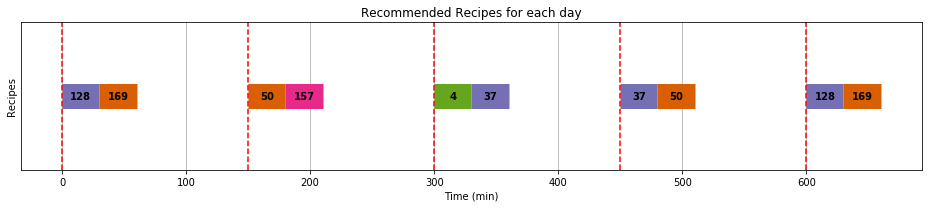

Solve  executes 2.734 s
SolveForAlternative  executes 2.734 s
Ys: [(0, 0, 157), (0, 0, 169), (0, 1, 4), (0, 3, 50), (0, 4, 128), (0, 4, 169), (1, 0, 50), (1, 0, 128), (1, 2, 37), (1, 3, 37)]
Xs: [(0, 128), (0, 169), (1, 50), (1, 157), (2, 4), (2, 37), (3, 37), (3, 50), (4, 128), (4, 169)]
----------------------------------------------------------------------------------------------------
Solution3 :


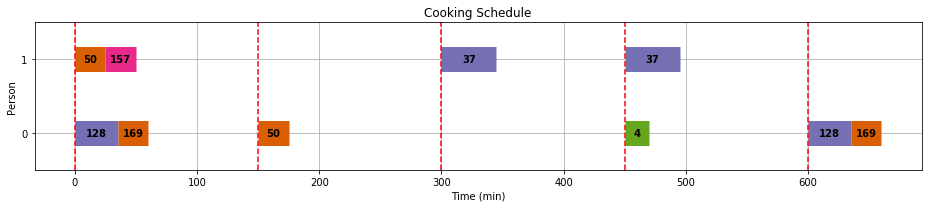

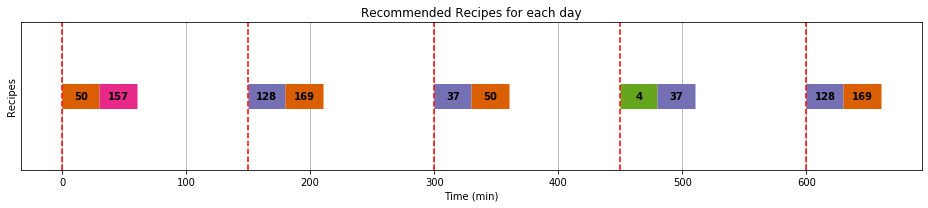

Solve  executes 2.313 s
SolveForAlternative  executes 2.313 s
Ys: [(0, 0, 128), (0, 0, 169), (0, 1, 50), (0, 3, 4), (0, 4, 128), (0, 4, 169), (1, 0, 50), (1, 0, 157), (1, 2, 37), (1, 3, 37)]
Xs: [(0, 50), (0, 157), (1, 128), (1, 169), (2, 37), (2, 50), (3, 4), (3, 37), (4, 128), (4, 169)]
----------------------------------------------------------------------------------------------------
Solution4 :


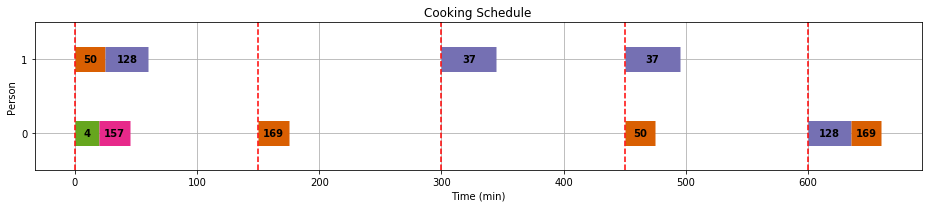

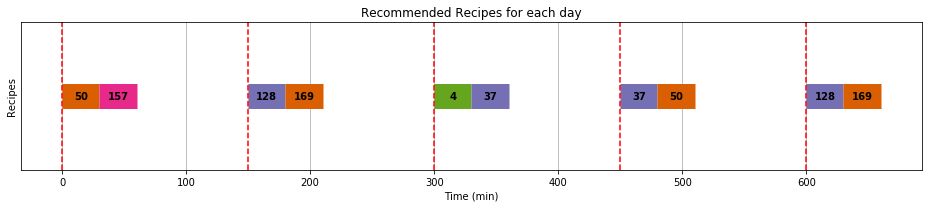

Solve  executes 2.303 s
SolveForAlternative  executes 2.303 s
Ys: [(0, 0, 4), (0, 0, 157), (0, 1, 169), (0, 3, 50), (0, 4, 128), (0, 4, 169), (1, 0, 50), (1, 0, 128), (1, 2, 37), (1, 3, 37)]
Xs: [(0, 50), (0, 157), (1, 128), (1, 169), (2, 4), (2, 37), (3, 37), (3, 50), (4, 128), (4, 169)]
----------------------------------------------------------------------------------------------------
Solution5 :


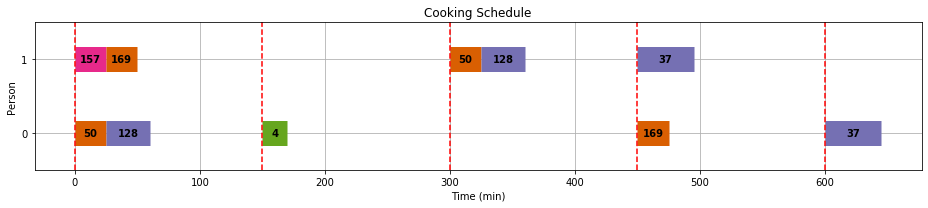

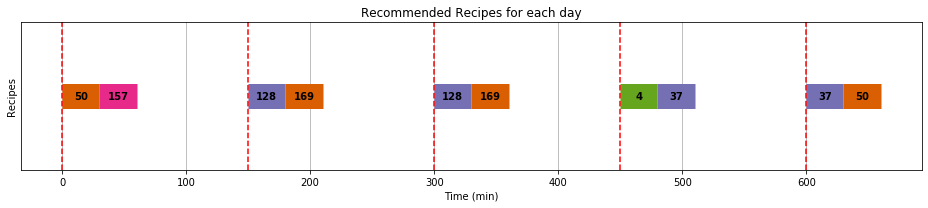

Solve  executes 2.574 s
SolveForAlternative  executes 2.574 s
Ys: [(0, 0, 50), (0, 0, 128), (0, 1, 4), (0, 3, 169), (0, 4, 37), (1, 0, 157), (1, 0, 169), (1, 2, 50), (1, 2, 128), (1, 3, 37)]
Xs: [(0, 50), (0, 157), (1, 128), (1, 169), (2, 128), (2, 169), (3, 4), (3, 37), (4, 37), (4, 50)]
----------------------------------------------------------------------------------------------------
Solution6 :


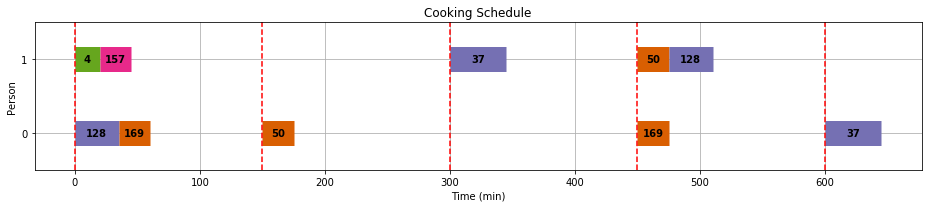

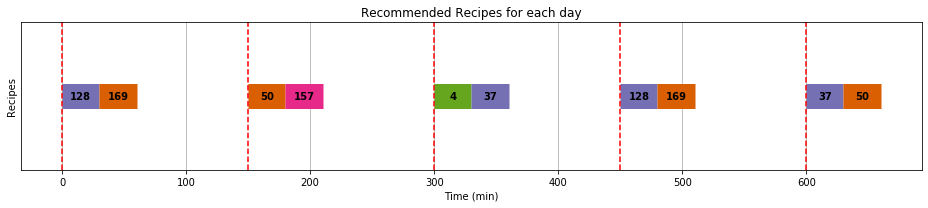

Solve  executes 2.473 s
SolveForAlternative  executes 2.473 s
Ys: [(0, 0, 128), (0, 0, 169), (0, 1, 50), (0, 3, 169), (0, 4, 37), (1, 0, 4), (1, 0, 157), (1, 2, 37), (1, 3, 50), (1, 3, 128)]
Xs: [(0, 128), (0, 169), (1, 50), (1, 157), (2, 4), (2, 37), (3, 128), (3, 169), (4, 37), (4, 50)]
----------------------------------------------------------------------------------------------------
Solution7 :


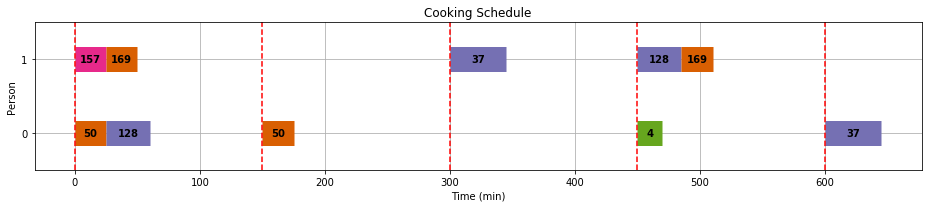

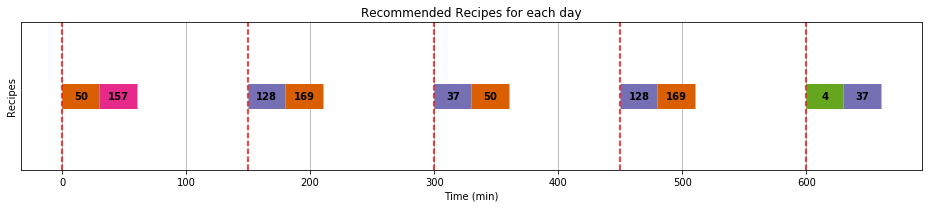

Solve  executes 2.268 s
SolveForAlternative  executes 2.268 s
Ys: [(0, 0, 50), (0, 0, 128), (0, 1, 50), (0, 3, 4), (0, 4, 37), (1, 0, 157), (1, 0, 169), (1, 2, 37), (1, 3, 128), (1, 3, 169)]
Xs: [(0, 50), (0, 157), (1, 128), (1, 169), (2, 37), (2, 50), (3, 128), (3, 169), (4, 4), (4, 37)]
----------------------------------------------------------------------------------------------------
Solution8 :


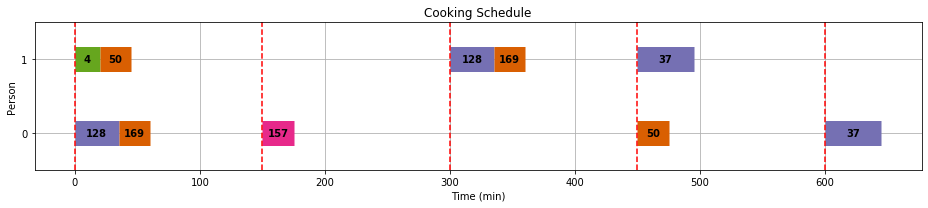

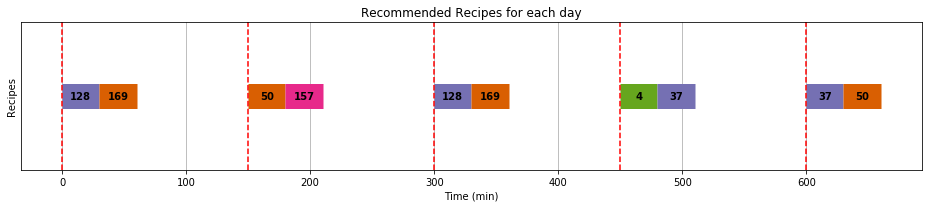

Solve  executes 2.21 s
SolveForAlternative  executes 2.21 s
Ys: [(0, 0, 128), (0, 0, 169), (0, 1, 157), (0, 3, 50), (0, 4, 37), (1, 0, 4), (1, 0, 50), (1, 2, 128), (1, 2, 169), (1, 3, 37)]
Xs: [(0, 128), (0, 169), (1, 50), (1, 157), (2, 128), (2, 169), (3, 4), (3, 37), (4, 37), (4, 50)]
Solution repeated.


In [9]:
print("Solution1:")
c = modelClass(data)
c.Solve()
print("Ys:", c.ys)
print("Xs:", c.xs)
s = 2
prexs = []
repeated = False
while c.xs and s <= 50 and not repeated:
    prexs.append(c.xs)
    print('-'*100)
    print("Solution"+str(s),':')
    c.SolveForAlternative()
    print("Ys:", c.ys)
    print("Xs:", c.xs)
    s += 1
    
    # check for repeated solution
    for prex in prexs:        
        if c.xs == prex:
            repeated = True
            break

if c.xs and not repeated:
    print("There are more than",s-1,"alternatives. ")
elif repeated:
    print("Solution repeated.")